<a href="https://colab.research.google.com/github/Brentlang/cap-comp215/blob/main/Brent-Project_2_ForestFires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Two Forest Fire simulation extension


Name: Brent Langford

**Before continuing Press Run all under Runtime tab**

Each cell is in one of four states: empty, occupied by forest, wet, or on fire.

5 ecological processes are modelled: forest regeneration, fire ignition, and fire spread

  * empty cells "regenerate" forest at a fixed rate, $p$
  * empty cells with two or more occupied neighbors will become occupied with a rate of $g$
  * forest fires ignite with a regular but small frequency, $f$
  * forested cells catch fire when their neighbours are burning, and burn out in one time step.



In [1]:
%matplotlib inline

import time
import pprint
import statistics
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d
from scipy.stats import linregress
from importlib import reload

import numpy.random
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

# Had to add this because it was saying that plot.title was a string,
# think it may be because of the animation 
plt=reload(plt)


### Helpers
Some useful, re-usable bits of code developed in previous notebooks...

In [2]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)


In [3]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

#River Class:


In [4]:
class River:
    def __init__(self, n):
        # creates n by n array of zeroes
        self.grid = np.zeros((n, n))
        # randomly makes a value in the top row a 1
        self.grid[0, np.random.randint(n)] = 1
        
    def step(self):
        # retrieves shapes
        n = self.grid.shape[0]
        # exludes the first row when iterating
        for i in range(1,n):
            for j in range(n):
                left = self.grid[i-1, max(j-1, 0)]
                right = self.grid[i-1, min(j+1, n-1)]
                center = self.grid[i-1, j]
                if np.random.choice([False, True]):
                    self.grid[i, j] = max(left, center, right)
                else:
                    self.grid[i, j] = 0
     
        return self.grid




* The step function will be more complex because it must implement the 4 rules:

  *  An empty cell becomes occupied with probability $p$.
  *  A cell with a tree burns if any of its neighbors is on fire.
  *  A cell with a tree spontaneously burns, with probability $f$, even if none of its neighbors is on fire.
  *  A cell with a burning tree becomes an empty cell in the next time step.

Typical values for the parameters are $p=0.01$ and $f=0.001$

# Forest Fire Class:

In [5]:
class ForestFire:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 4 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5
    # New value to represent the river
    WET=20
    

    # Define a colour map that maps each cell state to an intuitive colour.
    # Creates white colour map by default for every value that is not defined
    # Assigns a colour for each index
    cmap = [(0,0,0) for i in range(0,WET+1)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    cmap[WET] = (0, 0, 1)   # blue
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # Correlation kernel for 
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])
    # Brings moisture value to cells near the river
    moist= np.array([[0.1, 0.1, 0.1],
                     [0.1,  1,  0.1],
                     [0.1, 0.1, 0.1]])


    def __init__(self, n, p=0.01, f=0.001, q=0.3,g=0.01,river_flow=False):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous file (e.g., 1/fire ignition int erval)
        q: initial forest density (probability cell is "forested" in initial state)
        g: the probability an empty cell with more than one forested neighbors drops seeds and grows a tree
        river_flow: T/F addition to the forest fire model where a random river can be overlayed and effect f values for each cell or not
        """
        self.p = p
        self.f = f
        self.g = g
        self.river_flow=river_flow
      
        
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.array = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])
        #Initializes s a random river pattern on the same size grid as the foresfire model 
        if self.river_flow==True:
          # sets up array of zeroes with a 1 randomly placed in the top row
          self.river=River(n)

          # Creates the random river pattern from the 1 in the top row
          self.river=self.river.step()

          # Uses the sliding dot product for the diffusion to take place
          self.moist_spread=correlate2d(self.river,self.moist,mode='same')

          # Overlays the river onto the forestfire model giving the river cells a value of 20 on the forestfire model
          self.array[self.river==1]=self.WET
        else:
          # If river_flow == False no diffusion takes place and the percent chance of an occupied cell catching fire
          # will be f because every moisture value in moist_spread is zero and the chance of the occupied cell catching fire is 
          # self.f-self.f*self.moist_spread 
          # If river_flow == False it creates an array of zero values
          self.moist_spread = np.zeros((n,n))


    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        
       
        transitions = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
        occupied = (self.array == 1)
        neighbours_on_fire = (transitions<20)&(transitions >= 5)
        neighbours_not_on_fire = (transitions < 5)
        neighbours_occupied= (transitions>=2) & (transitions<5)
        empty = (self.array == 0)
        fire= (self.array == 5)

        

        # #occupied cell catches on fire with f
        # each cell catches fire with % depending on ground moisture if River flow
        # is true otherwise original fire catching probability
        if self.river_flow==True:
          row,col = self.array.shape
          for r in range(row):
              for c in range(col):
                 if self.array[r,c]==1:
                    self.array[r,c]=np.random.choice( 
                    [5, 1],
                    p = [self.f-self.f*self.moist_spread[r,c], 1-(self.f-self.f*self.moist_spread[r,c])])
                 else:
                    pass 
        else:
          self.array[occupied] = np.random.choice( 
            [self.FIRE, self.OCCUPIED],
            self.array[occupied].shape,
            p = [self.f, 1-self.f]
            )       


        #occupied cell catches on fire
        self.array[neighbours_on_fire & occupied] = self.FIRE
      
      
        #empty cell grows tree with p
        self.array[empty] = np.random.choice( 
            [self.OCCUPIED, self.EMPTY],
            self.array[empty].shape,
            p = [self.p, 1-self.p]
            ) 
        
       
        #empty cell with 2 occupied neighbors grows with g  
        if self.g>0:
          self.array[empty & neighbours_occupied] = np.random.choice( 
              [self.OCCUPIED, self.EMPTY],
              self.array[empty & neighbours_occupied].shape,
              p = [self.g, 1-self.g]
              )
        else:
          pass
        
       
        # Fire cell puts its self out after spreading
        self.array[fire]=0
       
        return self
        
    def num_occupied(self):
        """ return the number of cells occupied by forest """
        return sum(sum(self.array==1))

    def river_occupy(self):
        # finds the number of river cells in the array
        return sum(sum(self.array==20))

    def river_pct_occupied(self):
        # finds the % of river cells in the array
        return self.river_occupy() / self.array.size

    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.array.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.gca()
        graph_title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2D_array(self.array, axes=axes, title=graph_title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))


# Original Forest Fire Model:

In [6]:
model_noriv=ForestFire(10,river_flow=False,g=0) 
ani_forestfire=Animation2D(model_noriv, frames=50)
aff=ani_forestfire.show()     
aff



# Forest Fire Model With Neighbour Growth Function:

In [7]:
model_noriv=ForestFire(10,river_flow=False,g=.75) 
ani_forestfire=Animation2D(model_noriv, frames=50)
aff=ani_forestfire.show()     
aff

# New Forest Fire Model Including River Flow:

In [8]:
model_riv=ForestFire(10,river_flow=True)
ani_riv=Animation2D(model_riv, frames=50)
ani_riv.show()

# Functions For Analysis Of Forest Fire Model:

In [9]:

def model_pct(size,step,q,f,p,g,river_flow):
  # returns a list of steps [1,2,3...steps], a list of percent occupied values
  # and a list of river percent occupation which is a constant value
  model=ForestFire(size,p,f,q,g,river_flow)
  # steps model to reach equilibrium
  for i in range(100):
    model.step()
  pct=[model.step().pct_occupied() for i in range(step)]
  steps=[ i for i in range(step)]
  riv_pct=model.river_pct_occupied()
  return steps,pct,riv_pct

def model_median_pct(size,step,q,f,p,g,river_flow,quant_models):
  median_pcts=[]
  # for every model it finds the percent occupied for each step and then finds the
  # median of the percent occupied for each step and adds it to a list called median_pcts after its done
  # looping throught the models it returns the list of median percents
  for i in range(quant_models):
    model=ForestFire(size,p,f,q,g,river_flow)
    pct=[model.step().pct_occupied() for i in range(step)]
    median_pcts.append(statistics.median(pct))
  return median_pcts

def average_list(list_vals):
    # calculates the moving average
    result = []
    for i in range(len(list_vals)):
        if i == 0:
            result.append(list_vals[0])
        else:
            avg = sum(list_vals[:i+1]) / (i+1)
            result.append(avg)
    return result

def pct_change_list(list_vals):
  # finds the percent change from value to value from the list list_vals
  # disregards the last value which means I will have to decrease the steps when I graph
  pct_chng=[]
  for i in range(len(list_vals)):
    if list_vals[i]!=list_vals[-1]:
      pct_chng.append((list_vals[i+1]-list_vals[i])/list_vals[i])
    else:
      pass
  return pct_chng


def compare_graphs(width_quan,height_quan,flow, steps_quan,dims):
    plt.subplots(height_quan, width_quan, figsize=(18, 6),constrained_layout=True,sharey=True)
    gs=[0,0.05,0.20,0.50,0.75,1]
    for plot, g in enumerate(gs):
        plt.subplot(height_quan, width_quan, plot+1)
        plt.xlabel("Steps")
        plt.ylabel("Percent Occupied %")

        steps,pct,riv_pct=model_pct(size=dims, step=steps_quan,q=.5,f=.001,p=.01,g=g,river_flow=flow)
        # makes pct change list the same size as steps list by zipping and unpacking the zip
        steps_and_change_pct_zip=zip(steps,pct_change_list(pct))
        step_pct_change , percent_list = zip(*steps_and_change_pct_zip)

        plt.plot(step_pct_change,percent_list)
        plt.plot(steps,pct)
        # adds a river pct line and a title for river pct if tbere is a river value in the array
        if riv_pct>0:
          # plots river percentage occupied over steps
          plt.plot(steps,[riv_pct for i in steps])
          plt.title(f'Growth rate is {g},river occupied is {round(riv_pct*100,6)}%, median occupied {round(statistics.median(pct)*100,2)}%')
         
        else:
          plt.plot(steps,average_list(pct))
          plt.title(f'The growth rate is {g} and median occupied {round(statistics.median(pct)*100,2)}%')


# The New Cluster Growing Function varying with rate g:


*   Below are many graphs displaying the changes in behaviour due to a varying g values:



*   The orange line shows the percent of occupied cells in the Forest Fire model after each step
*   The green line represents a moving average of the percent of occupied cells at each step 
*   The blue line shows the percent change of occupied cells for each step.
*   As the $g$ value increases the likelihood that an empty cell with at least two occupied neighbors will itself become occupied increases

---
# Findings:

*   Increasing $g$ makes patches grow faster leading to a higher percent of occupied cells. This produces more devastating effects once a cell catches fire as it is increasingly likely that the cell has a occupied neighbor, therefore the fire spreads throughout the array.
*   The pattern as $g$ increases creates higher peaks and troughs with a higher frequency because of the faster increase in occupied cells and greater fire devastation.
*   When $g$ is zero there is no neighbor growing effect so it takes longer for occupied cells to build up and for fires to have devastating effects. Fires may occur but they most likely won't have widespread effects until the percent occupied critical threshold of around 35%-40% is hit. This means the large fire devastation has a longer cyclical period.










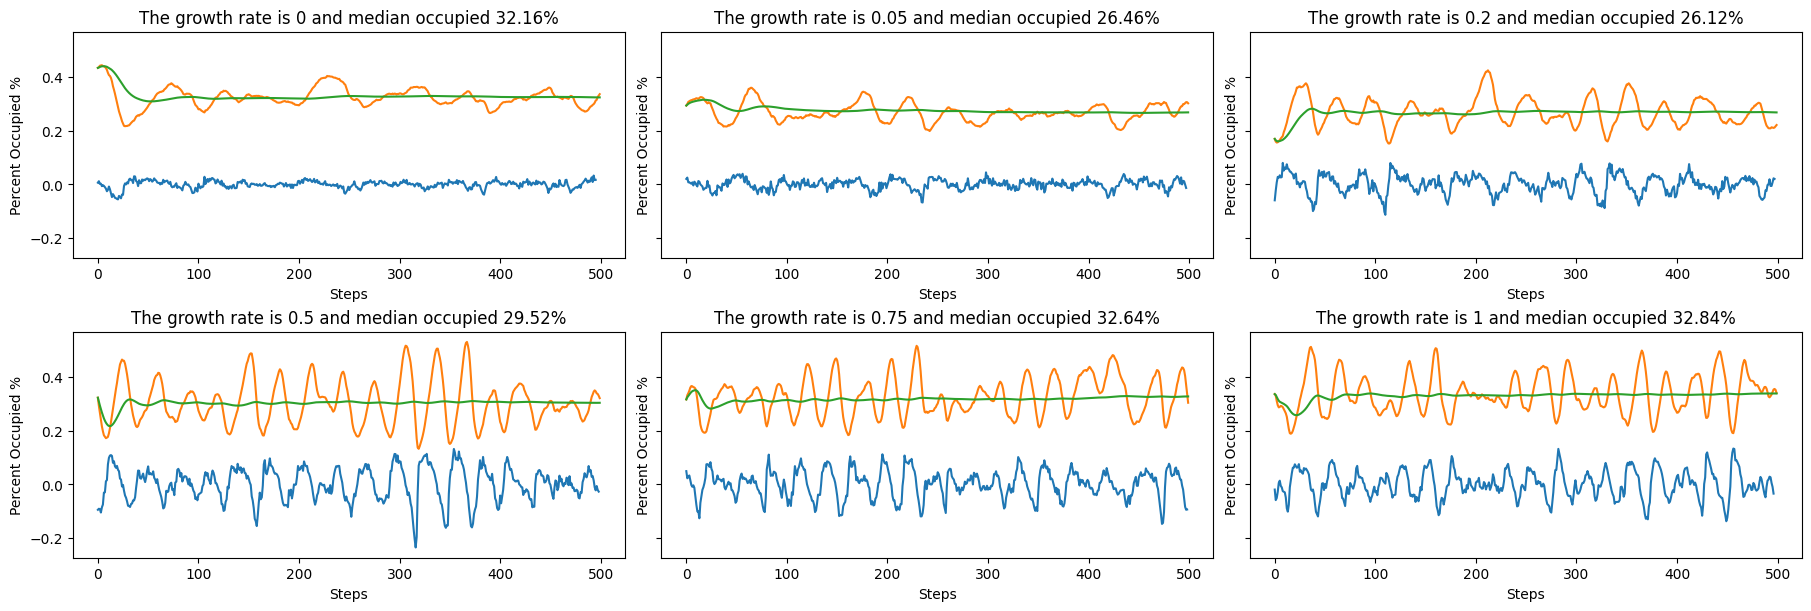

In [10]:
compare_graphs(width_quan=3,height_quan=2,flow=False, steps_quan=500,dims=50)

# With The River Enabled:



*   The green line is the constant river occupied percentage

*   From what I have witnessed with the River enabled the peaks and troughs caused by fire spreading through patches of occupied cells are less severe than with the river flow disabled. Intuitively this makes sense as the river can segment the graph meaning it can prevent the spreading of patches.

*   The higher the river occupied percentage is the more segmented the array is meaning less severity if a fire breaks out because there is a natural blockade.



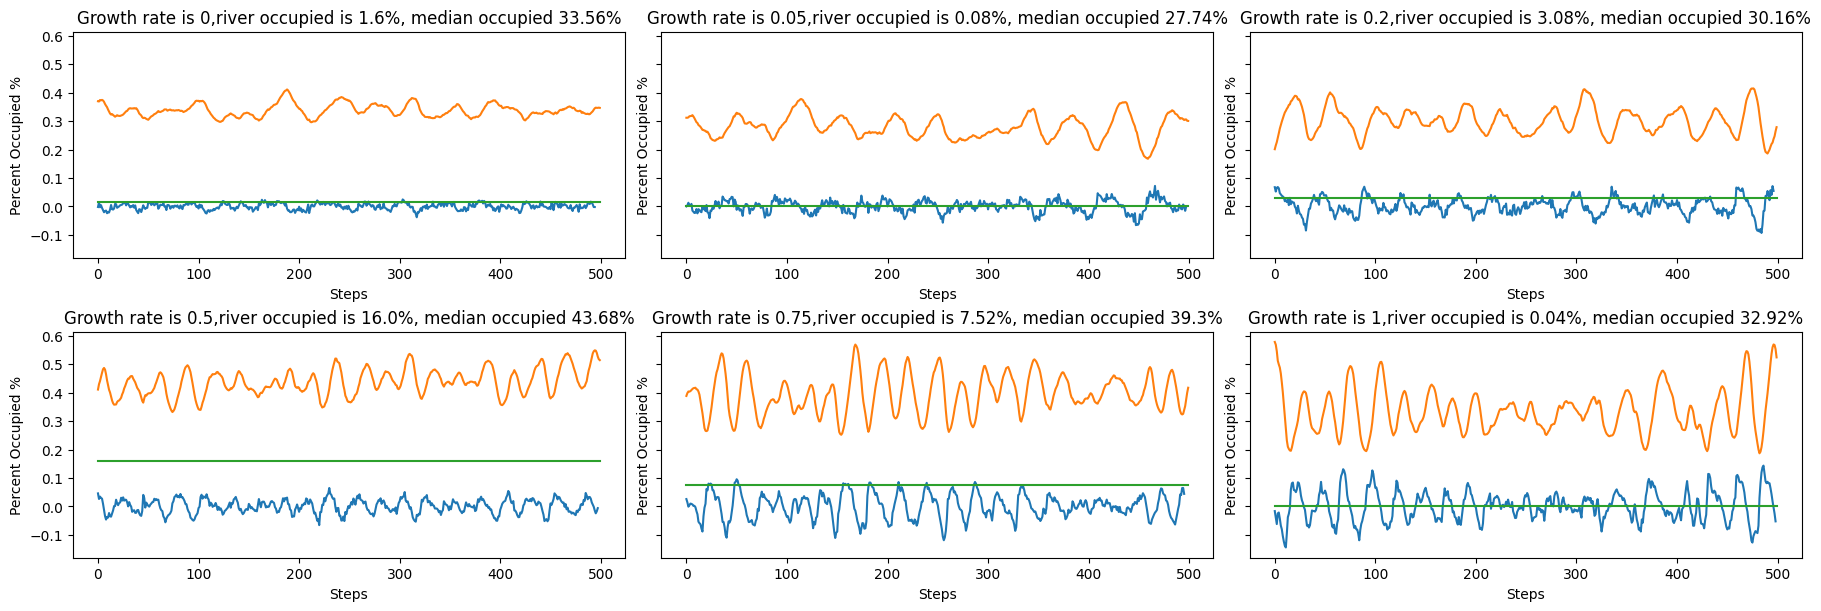

In [11]:
compare_graphs(width_quan=3,height_quan=2,flow=True, steps_quan=500,dims=50)

# River Flow == True


*   Below is a graph with the median occupied values for 150 models with 300 steps per model
*   As $g$ increases for the neighboring growth function the volatility also increases having greater variances and standard deviations. Due to faster growing patch sizes, when a fire occurs its damage is more severe on average with a higher growth rate.



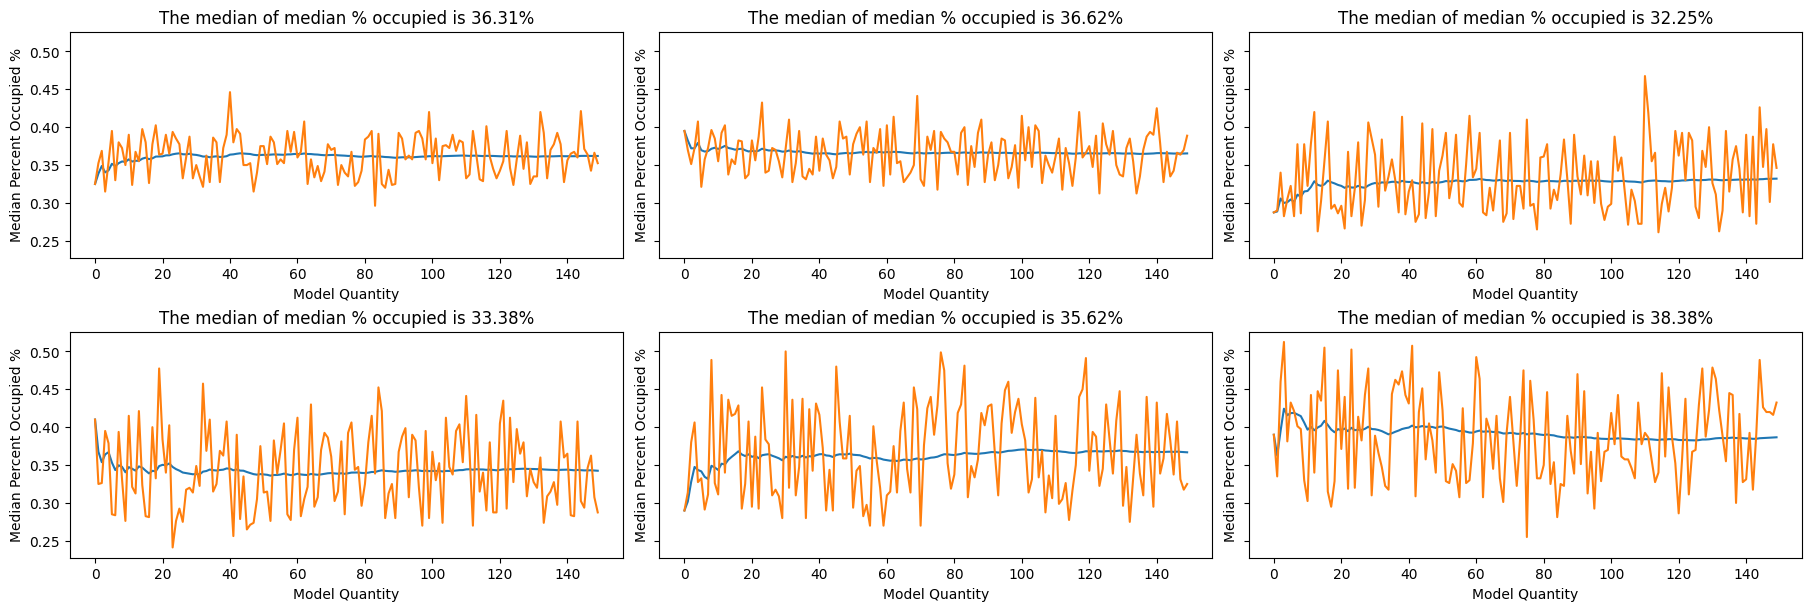

In [12]:
model_amount=150
height_quan=2
width_quan=3
plt.subplots(height_quan, width_quan, figsize=(18, 6),constrained_layout=True,sharey=True)
gs=[0,0.01,0.05,0.20,0.50,0.75]
for plot, g in enumerate(gs):
    plt.subplot(height_quan, width_quan, plot+1)
    plt.xlabel("Model Quantity")
    plt.ylabel("Median Percent Occupied %")
    median_occupied=model_median_pct(size=20, step=300,q=.5,f=.001,p=.01,g=g,river_flow=True,quant_models=model_amount)
    plt.title(f'The median of median % occupied is {round(statistics.median(median_occupied)*100,2)}%')
    plt.plot([i for i in range(model_amount)], average_list(median_occupied))
    plt.plot([i for i in range(model_amount)],median_occupied)

-------------------